In [1]:
import numpy as np
import cvxpy as cvx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from scipy import sparse
from solvers import util


In [2]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = sparse.lil_matrix((6*n_agent, 6*n_agent))
    B_tot = sparse.lil_matrix((6*n_agent, 3*n_agent))
    A = sparse.csc_matrix([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = sparse.csc_matrix([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot
        

In [3]:
Ad, Bd = linear_kinodynamics(0.1,3)

In [4]:
def solve_scp( Ad, Bd,
                     P: np.ndarray,
                      Q: np.ndarray,
                      R: np.ndarray,
                      N: int,
                      s_goal: np.ndarray,
                      s0: np.ndarray,
                      ρ: float,
                      tol: float,
                      max_iters: int,
                      coll_radius: float):
    """Solve the cart-pole swing-up problem via SCP."""
    n = Q.shape[0]  # state dimension
    m = R.shape[0]  # control dimension
    n_drones = 3
    # Initialize nominal trajectories
    u_bar = np.random.rand(N, m)
    s_bar = np.random.rand(N+1, n)
    s_bar[0] = s0.reshape(1,-1)
    for k in range(N):
        s_bar[k+1] = Ad @ s_bar[k] + Bd @ u_bar[k]
        
    """Use a straight line initialization instead"""
    # waypoints = init_trajectory(N, m, x0, xr, 3, 6)
    # s_bar = np.zeros((N+1, n))
    # for k in range(N+1):
    #     s_bar[k][dpilqr.pos_mask(x_dims,3)] = waypoints[k]
    # u_bar = np.zeros((N, m))
    
    # Do SCP until convergence or maximum number of iterations is reached
    converged = False
    obj_prev = np.inf
    iterate = 0
    s_prev = None
    for i in (prog_bar := tqdm(range(max_iters))):
        s, u, obj = scp_iteration(Ad, Bd, P, Q, R, N, s_bar, u_bar, s_goal, s0,
                                  ρ, iterate,  s_prev, n_drones, coll_radius)
        iterate += 1
        diff_obj = np.abs(obj - obj_prev)
        prog_bar.set_postfix({'objective change': '{:.5f}'.format(diff_obj)})

        if diff_obj < tol:
            converged = True
            print('SCP converged after {} iterations.'.format(i))
            break
        else:
            obj_prev = obj
            np.copyto(s_bar, s)
            np.copyto(u_bar, u)
        
        s_prev = s
        
    if not converged:
        raise RuntimeError('SCP did not converge!')

    return s, u




In [21]:
def scp_iteration(Ad, Bd, P: np.ndarray, Q: np.ndarray, R: np.ndarray,
                  N: int, s_bar: np.ndarray, u_bar: np.ndarray,
                  s_goal: np.ndarray, s0: np.ndarray,
                  ρ: float, iterate: int, s_prev: np.ndarray, n_drones: int, collision_radius: float):
    """Solve a single SCP sub-problem for the cart-pole swing-up problem."""
    # A, B, c = linearize(fd, s_bar[:-1], u_bar)
    # A, B, c = np.array(A), np.array(B), np.array(c)

    n = Q.shape[0]
    m = R.shape[0]

    s_cvx = cvx.Variable((N + 1, n))
    u_cvx = cvx.Variable((N, m))

    # INSTRUCTIONS: Construct and solve the convex sub-problem for SCP.

    # TODO: Replace the two lines below with your code.
    objective = 0.

    constraints = []
    constraints +=[s_cvx[0,:] == s_bar[0]]
    
    for k in range(N):
        
        objective += cvx.quad_form(s_cvx[k,:] - s_goal.flatten(), Q) + cvx.quad_form(u_cvx[k,:], R) 

        constraints += [s_cvx[k+1,:] == Ad@s_cvx[k,:] + Bd@u_cvx[k,:]]
    
        for i in range(n_drones):

            constraints += [np.array([-3, -3, -3]) <= u_cvx[k, i*3:(i+1)*3], \
                                u_cvx[k, i*3:(i+1)*3] <= np.array([3, 3, 3])]
                            
            #linearized collision avoidance constraints
            # if iterate > 0:
            #     prev_pos = [s_prev[k][id:id+6] for id in range(0, len(s_prev[k]), 6)]
            #     curr_pos = [s_cvx[k][id:id+6] for id in range(0, len(s_prev[k]), 6)]
            #     for j in range(n_drones):
            #         if j != i:
            #             constraints+= [cvx.norm(prev_pos[i][0:3]-prev_pos[j][0:3]) + \
            #                         (prev_pos[i][0:3].T-prev_pos[j][0:3].T)/cvx.norm(prev_pos[i][0:3]-prev_pos[j][0:3])
            #                         @ ((curr_pos[i][0:3]-curr_pos[j][0:3]) - \
            #                            (prev_pos[i][0:3]-prev_pos[j][0:3])) >= collision_radius]

        #Note: without the following convex trust regions, the solution blows up 
        #just after a few iterations
        constraints += [cvx.pnorm(s_cvx[k,:]-s_bar[k,:],'inf') <= ρ]
        constraints += [cvx.pnorm(u_cvx[k,:]-u_bar[k,:],'inf') <= ρ]

    objective += cvx.quad_form(s_cvx[-1,:] - s_goal.flatten(), P)

    prob = cvx.Problem(cvx.Minimize(objective), constraints)
    prob.solve(verbose=True)  
  
    if prob.status != 'optimal':
        raise RuntimeError('SCP solve failed. Problem status: ' + prob.status)

    s = s_cvx.value
    u = u_cvx.value
    
    obj = prob.objective.value

    return s, u, obj

In [22]:
def compute_pairwise_distance_CVX(X, x_dims, n_dims):
    """Analog to the above whenever some agents only use distance in the x-y plane"""
    CYLiER_RADIUS = 0.2

    n_states = x_dims[0]
    n_agents = len(x_dims)
    distances = []
    eps = 1e-3

    for i, n_dim_i in zip(range(n_agents), n_dims):
        for j, n_dim_j in zip(range(i + 1, n_agents), n_dims[i + 1 :]):
            n_dim = min(n_dim_i, n_dim_j)

            Xi = X[i * n_states : i * n_states + n_dim]
            Xj = X[j * n_states : j * n_states + n_dim]
            dX = Xi-Xj

            if n_dim == 3:
                # distances.append(cp.sqrt(dX[0]**2+dX[1]**2+dX[2]**2+eps))
                distances.append(cvx.norm(dX))
            else:
                distances.append(cvx.sqrt(dX[0]**2+dX[1]**2 + eps)+CYLiER_RADIUS)
    
    return distances

In [23]:
n = 18                                # state dimension
m = 9                                # control dimension
x0, xr = util.paper_setup_3_quads()
dt = 0.1                             # discrete time resolution
# T = 2.                              # total simulation time
n_agents = 3

# SCP parameters
P = 1e3*np.eye(n)                  # terminal state cost matrix
Q = np.diag([5, 5, 5, 1, 1, 1]*n_agents)  # state cost matrix
R = 1e-3*np.eye(m)                   # control cost matrix
ρ = 1.                               # trust region parameter
tol = 5e-1                           # convergence tolerance
max_iters = 100                      # maximum number of SCP iterations

# t = np.arange(0., T + dt, dt)
N = 30
coll_radius = 0.3
s, u = solve_scp(Ad, Bd, P, Q, R, N, xr, x0, ρ, tol, max_iters, coll_radius)
print(f's has shape {s.shape}, u has shape {u.shape}')

  0%|          | 0/100 [00:00<?, ?it/s]

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 21 11:44:02 AM: Your problem has 828 variables, 271 constraints, and 0 parameters.
(CVXPY) Jun 21 11:44:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 21 11:44:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 21 11:44:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 21 11:44:02 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jun 21 11:44:02 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

  1%|          | 1/100 [00:00<01:09,  1.43it/s, objective change=inf]

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 21 11:44:02 AM: Your problem has 828 variables, 271 constraints, and 0 parameters.
(CVXPY) Jun 21 11:44:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 21 11:44:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 21 11:44:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 21 11:44:02 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jun 21 11:44:02 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

  2%|▏         | 2/100 [00:01<01:06,  1.47it/s, objective change=13323.10351]

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 21 11:44:03 AM: Your problem has 828 variables, 271 constraints, and 0 parameters.
(CVXPY) Jun 21 11:44:03 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 21 11:44:03 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 21 11:44:03 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 21 11:44:03 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jun 21 11:44:03 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

  2%|▏         | 2/100 [00:02<01:46,  1.08s/it, objective change=13323.10351]

9800   1.7100e+03   2.75e-03   5.05e-02   1.93e+01   5.16e-01s
10000   1.7104e+03   2.64e-03   5.80e-02   1.93e+01   5.28e-01s

status:               maximum iterations reached
number of iterations: 10000
run time:             5.28e-01s
optimal rho estimate: 1.46e+01



SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [25]:
import dpilqr


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


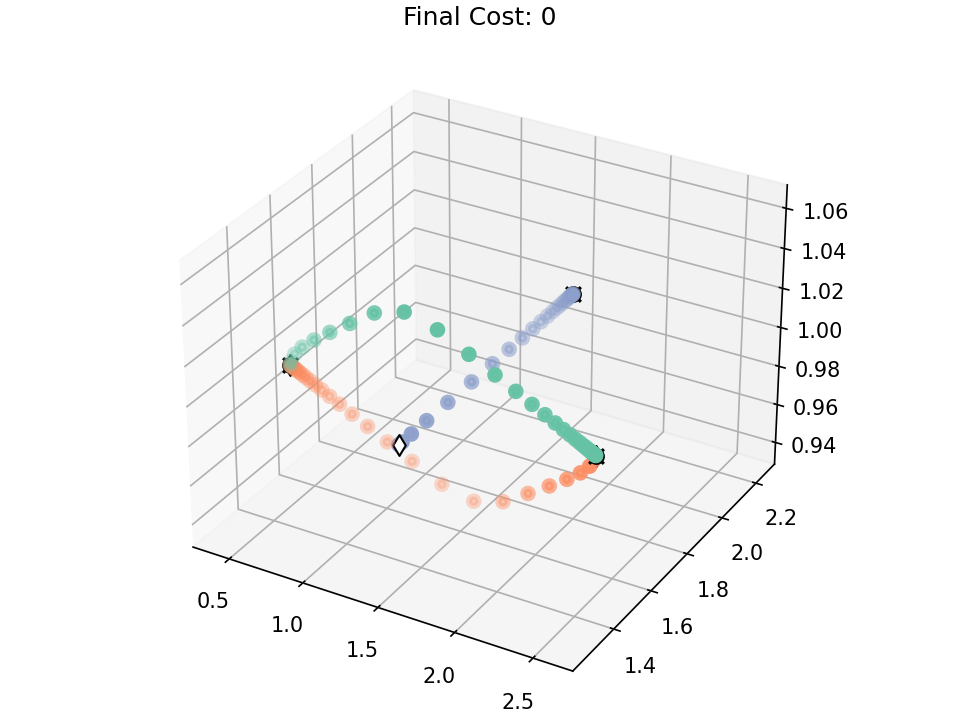

In [26]:
%matplotlib ipympl
plt.figure(dpi=150);
dpilqr.plot_solve(s,0,xr,[6,6,6],True,3);


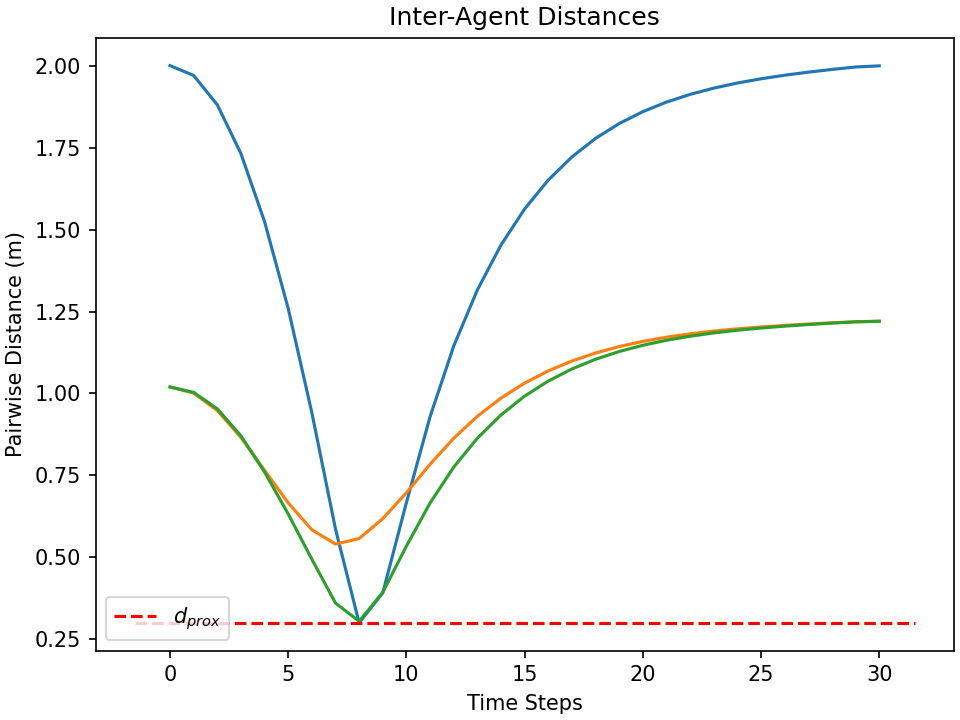

In [27]:
plt.figure(dpi=150)
dpilqr.plot_pairwise_distances(s, [6,6,6], [3,3,3], 0.3)
# plt.savefig('SCP_pairwise_distance.png')